# Grounded source with a casing 

Simulate a top casing source over a casing with the 3D cyl mesh

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
import time
from string import ascii_lowercase
import os

# empymod
import empymod

# SimPEG, discretize
import discretize
from discretize import utils
from simpeg.electromagnetics import frequency_domain as fdem
from simpeg.utils.solver_utils import get_default_solver

# from SimPEG.electromagnetics import time_domain as tdem
from simpeg import utils, maps, Report

from matplotlib import rcParams
rcParams["font.size"] = 12


In [2]:
from casing_utils import plot_slice

In [3]:
Solver = get_default_solver()
Solver

pymatsolver.direct.mumps.Mumps

In [4]:
Report()

--------------------------------------------------------------------------------
  Date: Tue Apr 15 22:25:43 2025 PDT

                OS : Darwin (macOS 13.7.4)
            CPU(s) : 12
           Machine : arm64
      Architecture : 64bit
               RAM : 64.0 GiB
       Environment : Jupyter
       File system : apfs

  Python 3.11.12 | packaged by conda-forge | (main, Apr 10 2025, 22:18:52)
  [Clang 18.1.8 ]

            simpeg : 0.23.0
        discretize : 0.11.2
       pymatsolver : 0.3.1
             numpy : 2.2.4
             scipy : 1.15.2
        matplotlib : 3.10.1
            geoana : 0.7.2
            libdlf : 0.3.0
             numba : 0.61.2
           IPython : 9.1.0
        ipywidgets : 8.1.6
--------------------------------------------------------------------------------

In [5]:
domain_x = 1000
domain_z = 1000

In [6]:
def pad_for_casing_and_data(
    casing_outer_radius,
    csx1=2.5e-3,
    csx2=25,
    pfx1=1.3,
    pfx2=1.5,
    domain_x=1000,
    npadx=10
):

    ncx1 = np.ceil(casing_outer_radius/csx1+2)
    npadx1 = np.floor(np.log(csx2/csx1) / np.log(pfx1))

    # finest uniform region
    hx1a = utils.unpack_widths([(csx1, ncx1)])

    # pad to second uniform region
    hx1b = utils.unpack_widths([(csx1, npadx1, pfx1)])

    # scale padding so it matches cell size properly
    dx1 = np.sum(hx1a)+np.sum(hx1b)
    dx1 = 3 #np.floor(dx1/self.csx2)
    hx1b *= (dx1*csx2 - np.sum(hx1a))/np.sum(hx1b)

    # second uniform chunk of mesh
    ncx2 = np.ceil((domain_x - dx1)/csx2)
    hx2a = utils.unpack_widths([(csx2, ncx2)])

    # pad to infinity
    hx2b = utils.unpack_widths([(csx2, npadx, pfx2)])

    return np.hstack([hx1a, hx1b, hx2a, hx2b])

In [13]:
# mesh parameters

casing_d = 1e-1  # 10 cm diameter
casing_b = casing_d / 2
casing_t = 2e-2  # 2 cm 
casing_a = casing_b - casing_t

casing_l = 500  # length of the casing

csx = 24  # min cell size in x
csz = 2  # z cell size (m)

pf = 1.5          # growth factor for cells in the pad zones 
npadx = 7          # number of pad cells after domain_max_x where growth is by pf factor
npadz = 12        # number of z pad cells above and below

hx = pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4,
    csx2=csx,
    pfx1=1.3,
    pfx2=pf,
    domain_x=domain_x,
    npadx=npadx
)

# Theta discretization
ny = 12
hy = np.ones(ny)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = 1.2*domain_z/csz 
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
cyl_mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print('Number of cells',cyl_mesh.n_cells)

Number of cells 696384


PolarAxes


[<PolarAxes: >, <Axes: xlabel='x', ylabel='z'>]

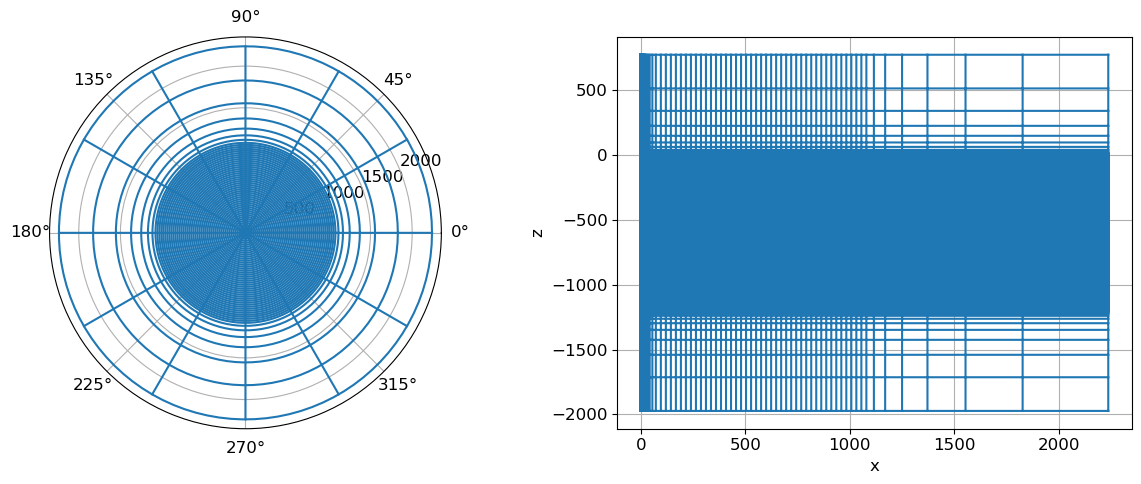

In [14]:
cyl_mesh.plot_grid()

## specify source location, survey geometry

In [15]:
src_x = np.r_[casing_b-casing_t/4, 300] 
src_z = -csz/2

In [16]:
src_theta = cyl_mesh.h[1][0]/2

src_a = np.r_[src_x[0], src_theta, src_z] 
src_b = np.r_[src_x[1], src_theta, src_z]

In [17]:
rx_x_extent = np.r_[2, 1000]
rx_x = cyl_mesh.nodes_x[(cyl_mesh.nodes_x > rx_x_extent[0]) & (cyl_mesh.nodes_x < rx_x_extent[1])]
rx_x

array([  2.41952199,   3.1322539 ,   4.05880538,   5.26332231,
         6.82919431,   8.86482792,  11.51115161,  14.95137241,
        19.42365944,  25.23763259,  32.79579768,  42.6214123 ,
        55.3947113 ,  72.        ,  96.        , 120.        ,
       144.        , 168.        , 192.        , 216.        ,
       240.        , 264.        , 288.        , 312.        ,
       336.        , 360.        , 384.        , 408.        ,
       432.        , 456.        , 480.        , 504.        ,
       528.        , 552.        , 576.        , 600.        ,
       624.        , 648.        , 672.        , 696.        ,
       720.        , 744.        , 768.        , 792.        ,
       816.        , 840.        , 864.        , 888.        ,
       912.        , 936.        , 960.        , 984.        ])

In [18]:
rx_theta = src_theta + np.pi/2 
rx_z = -csz*2

PolarAxes


(0.0, 2000.0)

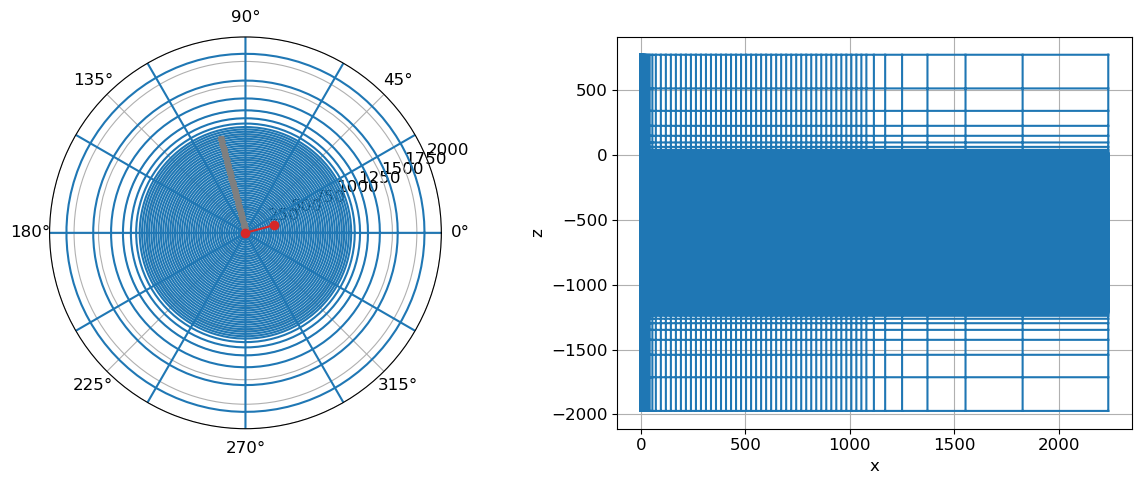

In [19]:
ax = cyl_mesh.plot_grid()

ax[0].plot(rx_theta * np.ones_like(rx_x), rx_x, "C7v", ms=4)
ax[0].plot([src_a[1], src_b[1]], [src_a[0], src_b[0]], "-C3o")
ax[0].set_rlim(0, 2000)

# set up SimPEG simulation

In [20]:
cement_diameter = 12e-2
cement_radius = cement_diameter / 2

In [21]:
freq = 0.5
sig_air = 1e-4
sig_halfspace = 1
sig_casing = 5e6
sig_fluid = 1/50 
sig_cement = 0.001 

In [22]:
sigma_model_halfspace = sig_halfspace * np.ones(cyl_mesh.n_cells)
sigma_model_halfspace[cyl_mesh.cell_centers[:, 2] > 0] = sig_air

In [23]:
cyl_mesh.cell_centers.shape

(696384, 3)

In [24]:
cyl_mesh.n_cells

696384

In [25]:
sigma_model_casing = sigma_model_halfspace.copy()

inds_casing = (
    (cyl_mesh.cell_centers[:, 0] < casing_b) & (cyl_mesh.cell_centers[:, 0] > casing_a) & 
    (cyl_mesh.cell_centers[:, 2] < 0) & (cyl_mesh.cell_centers[:, 2] > -casing_l)
)
sigma_model_casing[inds_casing] = sig_casing

inds_inside_casing = (
    (cyl_mesh.cell_centers[:, 0] < casing_a) &
    (cyl_mesh.cell_centers[:, 2] < 0) & (cyl_mesh.cell_centers[:, 2] > -casing_l)
)
sigma_model_casing[inds_inside_casing] = sig_fluid

inds_cement = (
    (cyl_mesh.cell_centers[:, 0] < cement_radius) & (cyl_mesh.cell_centers[:, 0] > casing_b) & 
    (cyl_mesh.cell_centers[:, 2] < 0) & (cyl_mesh.cell_centers[:, 2] > -casing_l)
)
sigma_model_casing[inds_cement] = sig_cement

(-700.0, 10.0)

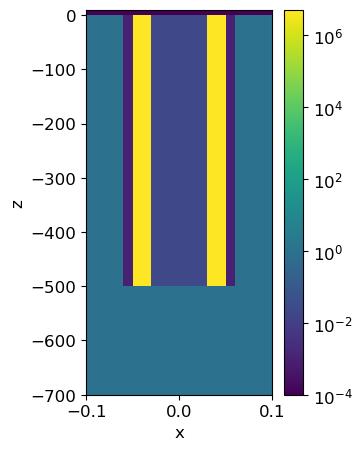

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
plot_slice(
    cyl_mesh, sigma_model_casing, pcolor_opts={"norm":LogNorm()}, ax=ax
)
ax.set_xlim(0.1*np.r_[-1, 1])
ax.set_ylim(np.r_[-700, 10])

In [27]:
src_locations = np.vstack([src_a, src_b])
receiver_locations = discretize.utils.ndgrid([rx_x, rx_theta, rx_z])

In [28]:
src_locations

array([[ 4.50000000e-02,  2.61799388e-01, -1.00000000e+00],
       [ 3.00000000e+02,  2.61799388e-01, -1.00000000e+00]])

In [29]:
rx_real = fdem.Rx.PointElectricField(locations=receiver_locations, orientation='x', component="real")
rx_imag = fdem.Rx.PointElectricField(locations=receiver_locations, orientation='x', component="imag")

rx_list = [rx_real, rx_imag]

In [30]:
src = fdem.sources.LineCurrent(frequency=freq, location=src_locations, receiver_list=rx_list)

survey = fdem.Survey([src])

In [31]:
sim = fdem.simulation.Simulation3DCurrentDensity(
    mesh=cyl_mesh, sigmaMap=maps.IdentityMap(cyl_mesh),
    survey=survey, solver=utils.solver_utils.get_default_solver(),
    verbose=True, forward_only=True
)

In [32]:
%%time
fields = sim.fields(sigma_model_casing)
data = sim.make_synthetic_data(sigma_model_casing, f=fields) 

/Users/lindseyjh/miniforge3/envs/2025-casing-demo/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 16min 2s, sys: 1min 20s, total: 17min 22s
Wall time: 2min 22s


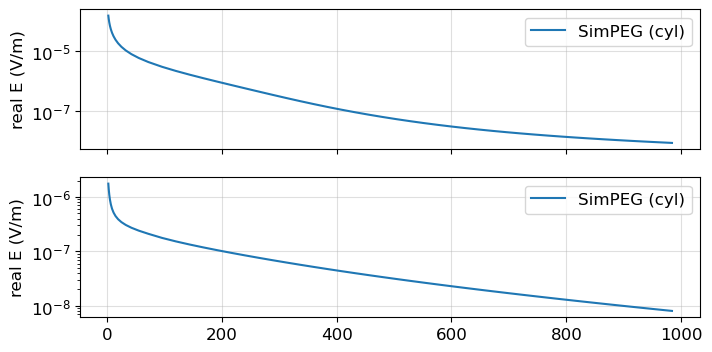

In [33]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

ax[0].semilogy(rx_x, np.abs(data[src, rx_real]), label="SimPEG (cyl)", color="C0")


ax[1].semilogy(rx_x, np.abs(data[src, rx_imag]), label="SimPEG (cyl)", color="C0")

ax[0].set_ylabel("real E (V/m)")
ax[1].set_ylabel("imag E (V/m)")
    
for a in ax.flatten():
    a.grid(alpha=0.4)
    a.legend()